In [1]:
# 1. retrive daily Bitcoin close price until today via API
import requests
url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&time_start=2021-01-01T00:00:00&limit=100000'
headers = {'X-CoinAPI-Key':'141B3FC7-26C7-4574-8309-E317DCFF7716'}
response = requests.get(url, headers=headers)
response = response.json()
price_close = [i['price_close'] for i in response]
print(price_close)
print(len(price_close))

[29402.64, 32216.53, 33097.83, 32005.88, 34039.05, 36849.94, 39510.49, 40667.07, 40239.06, 38173.73, 35455.58, 34035.02, 37393.49, 39134.35, 36756.57, 36000.0, 35819.25, 36616.95, 35917.62, 35496.91, 30818.18, 32992.06, 32117.49, 32288.83, 32261.22, 32504.53, 30424.62, 33484.87, 34249.64, 34323.0, 33141.38, 33532.74, 35522.16, 37691.63, 36996.32, 38320.0, 39282.1, 38858.39, 46416.45, 46505.2, 44854.63, 47981.48, 47395.84, 47228.48, 48662.5, 47942.57, 49166.53, 52174.28, 51579.54, 55988.58, 55936.04, 57492.91, 54173.65, 48887.93, 49754.0, 47088.58, 46314.83, 46109.98, 45240.96, 49629.33, 48516.35, 50379.68, 48360.5, 48739.21, 48904.63, 50967.3, 52427.8, 54929.02, 55852.29, 57772.09, 57271.04, 61165.19, 59016.39, 55644.37, 56908.34, 58901.8, 57648.05, 58072.0, 58138.39, 57381.79, 54070.92, 54361.57, 52287.52, 51326.11, 55081.37, 55839.42, 55790.92, 57600.1, 58760.59, 58782.58, 58728.53, 59003.6, 57064.42, 58212.18, 59125.0, 58018.3, 55932.83, 58096.6, 58109.56, 59766.93, 59979.26, 59831.

In [2]:
# 2. Calculate Log Returns
# could use list comprehensino here but I think the for loop is cleaner
import math
log_ret = []
for i in range(1, len(price_close)):
    logR = math.log(1+(price_close[i]-price_close[i-1])/price_close[i-1])
    log_ret.append(logR)
print(log_ret)
print(len(log_ret))

[0.09139520863493254, 0.02698804645502758, -0.03354808540178805, 0.06158875905283962, 0.07934559543889373, 0.06971221585846342, 0.02885246777879061, -0.01058050837106627, -0.052690582971823496, -0.07386693731907241, -0.0408906508566657, 0.09410663056831475, 0.04550397284705616, -0.0626836127548808, -0.020798046734502536, -0.005033480066198371, 0.022025789566966793, -0.019283265069954245, -0.011782332447471927, -0.14134087485442443, 0.06816215087056432, -0.02686618488874977, 0.005320608418656696, -0.0008554602725722808, 0.007513574525016895, -0.06612731517119134, 0.09584154595235118, 0.022582358684985426, 0.002139629682827666, -0.035033030734663025, 0.011739622351759786, 0.05763445208186461, 0.059281326803786095, -0.018619605651319007, 0.03515350486431477, 0.02479699127633854, -0.010844932065131473, 0.17772990995096738, 0.001910212033185636, -0.03613731812248899, 0.06738828694619464, -0.012280641985234967, -0.0035373606809219527, 0.029911612481005514, -0.014904876689716044, 0.0252092712

In [3]:
# 3. Calculate Parameters
import numpy as np
mean = sum(log_ret) / len(log_ret)
var = np.var(log_ret)
drift = mean - 0.5*var
std = np.std(log_ret)

In [4]:
# 4. Create Monte_Carlo_Simulation function
from scipy.stats import norm

def monte_carlo_simulation(periods, sims, latest_hist_close):    
    sim_paths = [0]*sims
    for s in range (0, sims):
        u = np.random.uniform(size=periods)
        Z = norm.ppf(u)
        
        daily_returns = [math.exp(drift + std*elem) for elem in Z]
        price_paths = [0] * periods
        price_paths[0] = latest_hist_close
        
        for t in range(1, periods):
            price_paths[t] = price_paths[t-1] * daily_returns[t-1]
        
        sim_paths[s] = price_paths
    
    return sim_paths

In [6]:
# Use timeit to show the execution time
%timeit monte_carlo_simulation(7, 100, price_close[-1])

14.1 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# 5. Build same function using numpy
def monte_carlo_simulation_vec(periods, sims, latest_hist_close):
    Z = norm.ppf(np.random.uniform(size=[sims, periods]))
    daily_rets = np.exp(drift+std*Z)
    s = latest_hist_close * np.ones([sims, periods])
    for i in range(1, periods):
        s[:, i] = s[:, i-1] * daily_rets[:, i-1]
    return s

In [8]:
# Use timeit to show the execution time
%timeit monte_carlo_simulation_vec(7, 100, price_close[-1])
# MUCH FASTER!

231 µs ± 9.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# 6. Plot the simulated with historical
# Simulated part
paths = monte_carlo_simulation_vec(8, 100, price_close[-1]) # because we want the next 7 days, so use 8 and then discard the first one, which is the last seen price
import pandas as pd
df_sim = pd.DataFrame(paths).T

In [10]:
# Historical Part, let's just take 10 days
hist = []
for i in range(-10,-1):
    row = [price_close[i]]*100
    hist.append(row)
hist_df = pd.DataFrame(np.array(hist))

In [11]:
# Concatenate both and add date as the index, 
df = pd.concat([hist_df, df_sim])
ind = ["2022-05-13", "2022-05-14", "2022-05-15", "2022-05-16", "2022-05-17", "2022-05-18", "2022-05-19", "2022-05-20", "2022-05-21", "2022-05-22", "2022-05-23", "2022-05-24", "2022-05-25", "2022-05-26", "2022-05-27", "2022-05-28", "2022-05-29"]
df.index = ind
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2022-05-13,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,...,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000,29238.810000
2022-05-14,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,...,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000,30033.960000
2022-05-15,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,...,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000,31295.030000
2022-05-16,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,...,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000,29832.450000
2022-05-17,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,...,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000,30425.360000
2022-05-18,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,...,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000,28681.260000
2022-05-19,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,...,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000,30290.330000
2022-05-20,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,...,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000,29176.700000
2022-05-21,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,...,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000,29421.050000
2022-05-22,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,...,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000,30179.060000


Text(0, 0.5, 'Close price (BTC/USDT)')

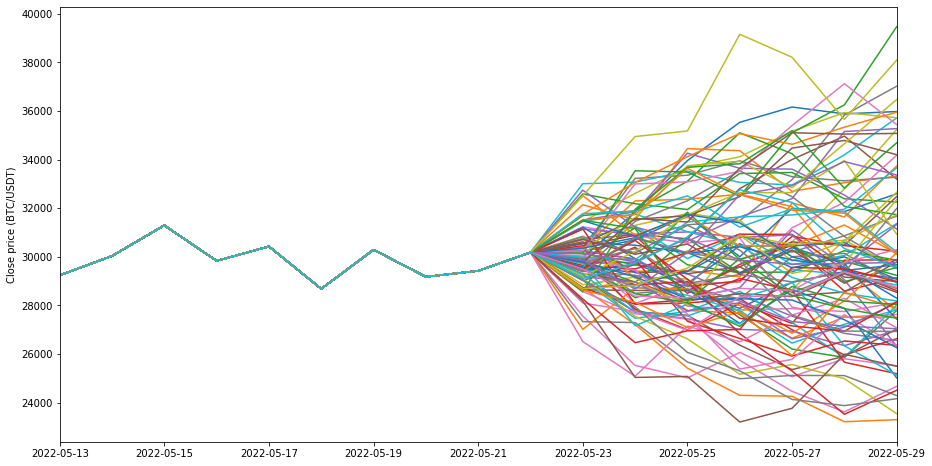

In [13]:
fig = df.plot(legend = None, figsize=(15, 8))
fig.set_ylabel("Close price (BTC/USDT)")

In [14]:
# 7. Plot the distribution of the simulated paths
points = paths[0][1:]
for i in range(1, len(paths)):
    points = np.concatenate((points, paths[i][1:]), axis = None)
len(points)

700

(array([  8.,   8.,  22.,  23.,  40.,  60.,  86., 106., 101.,  67.,  53.,
         37.,  33.,  17.,  19.,  12.,   3.,   1.,   2.,   2.]),
 array([23198.20231627, 24011.91828156, 24825.63424685, 25639.35021214,
        26453.06617743, 27266.78214273, 28080.49810802, 28894.21407331,
        29707.9300386 , 30521.64600389, 31335.36196918, 32149.07793448,
        32962.79389977, 33776.50986506, 34590.22583035, 35403.94179564,
        36217.65776093, 37031.37372623, 37845.08969152, 38658.80565681,
        39472.5216221 ]),
 <a list of 20 Patch objects>)

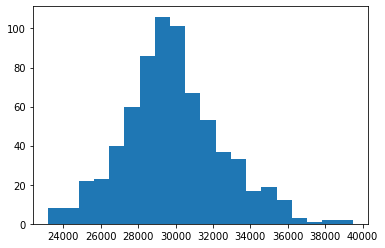

In [15]:
# Note the total count is 700
import matplotlib.pyplot as plt
plt.hist(points, bins = 20)

Text(0, 0.5, 'Frequency')

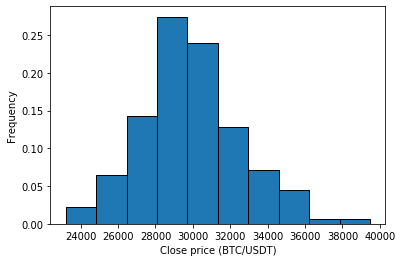

In [16]:
# Plot again with a different y axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(points, edgecolor = "black", weights = np.ones_like(points)/len(points))
ax.set_xlabel("Close price (BTC/USDT)")
ax.set_ylabel("Frequency")

In [17]:
# 8. Use numba package
import numba
from numba import jit
@jit(nopython=True)
def monte_carlo_simulation_vec_ba(periods, sims, latest_hist_close):
    Z = norm.ppf(np.random.uniform(size=[sims, periods]))
    daily_rets = np.exp(drift+std*Z)
    s = latest_hist_close * np.ones([sims, periods])
    for i in range(1, periods):
        s[:, i] = s[:, i-1] * daily_rets[:, i-1]
    return s

In [18]:
monte_carlo_simulation_vec_ba(7, 100, price_close[-1])

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'norm':[0m [1m[1mcannot determine Numba type of <class 'scipy.stats._continuous_distns.norm_gen'>[0m
[1m
File "<ipython-input-17-b50b2f3e8f8e>", line 6:[0m
[1mdef monte_carlo_simulation_vec_ba(periods, sims, latest_hist_close):
[1m    Z = norm.ppf(np.random.uniform(size=[sims, periods]))
[0m    [1m^[0m[0m
[0m
This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


It seems like that numba cannot be used to make our function faster because it doesn't recognize the scipy stats norm function. Apparently the available libraries that can be used with numba jit in nopython is fairly limited. From a little bit of dig-in on numba, it supports pretty much only numpy arrays and certain python builtin libraries.

In [ ]:
# see my comment on numba here ^